# Fuzzy matching test

In [1]:
import json
import random
import time
import matplotlib.pyplot as plt

## Import adminstrative region data

In [2]:
with open("./Data/region_tree.json", 'r') as file:
    region_tree = json.load(file)
    
with open("./Data/reverse_index_dist_to_prov.json", 'r') as file:
    rev_index_dist_to_prov = json.load(file)
    
with open("./Data/reverse_index_ward_to_prov.json", 'r') as file:
    rev_index_ward_to_prov = json.load(file)
    
with open("./Data/reverse_index_ward_to_dist.json", 'r') as file:
    rev_index_ward_to_dist = json.load(file)

In [3]:
all_provinces = [province['name'] for province in region_tree.values()]
all_districts = [district['name'] for district in rev_index_dist_to_prov.values()]
all_wards = [ward['name'] for ward in rev_index_ward_to_prov.values()]

## Read test case

In [4]:
with open("./AddressTestcase/public.json") as file:
    testcases = json.load(file)

In [5]:
tests = [testcase['text'] for testcase in testcases]
ground_truths = [testcase['result'] for testcase in testcases]

## Levenshtein distance

In [6]:
def levenshtein_dist(s1: str, s2: str) -> int:
    len_s1 = len(s1)
    len_s2 = len(s2)
    
    d = [[0]*(len_s2+1) for _ in range(len_s1+1)]
    
    for i in range(1, len_s1+1):
        d[i][0] = i
        
    for j in range(1, len_s2+1):
        d[0][j] = j
    
    for j in range(1, len_s2+1):
        for i in range(1, len_s1+1):
            if s1[i-1] == s2[j-1]:
                substitutionCost = 0
            else:
                substitutionCost = 1

            d[i][j] = min(d[i-1][j] + 1,
                          d[i][j-1] + 1,
                          d[i-1][j-1] + substitutionCost) 

    return d[-1][-1]

In [7]:
correct_str = 'Số 1410 Đường 30/4, Phường 12, Thành phố Vũng Tàu, Bà Rịa - Vũng Tàu.'
wrong_str = 'Bà Rịa - Vũng Tàu'

start = time.perf_counter_ns()

# find best match province
scores = [(levenshtein_dist(prov, correct_str), prov) for prov in all_provinces]
print(scores, '\n')
best_match_prov = min(scores, key=lambda score_prov : score_prov[0])
    
duration = time.perf_counter_ns() - start

print(best_match_prov)
print(duration / 1_000_000, 'ms')

[(67, 'Hà Nội'), (64, 'Hà Giang'), (65, 'Cao Bằng'), (66, 'Bắc Kạn'), (62, 'Tuyên Quang'), (66, 'Lào Cai'), (64, 'Điện Biên'), (66, 'Lai Châu'), (65, 'Sơn La'), (66, 'Yên Bái'), (65, 'Hoà Bình'), (63, 'Thái Nguyên'), (65, 'Lạng Sơn'), (64, 'Quảng Ninh'), (65, 'Bắc Giang'), (64, 'Phú Thọ'), (65, 'Vĩnh Phúc'), (66, 'Bắc Ninh'), (65, 'Hải Dương'), (64, 'Hải Phòng'), (64, 'Hưng Yên'), (64, 'Thái Bình'), (66, 'Hà Nam'), (65, 'Nam Định'), (64, 'Ninh Bình'), (63, 'Thanh Hóa'), (65, 'Nghệ An'), (65, 'Hà Tĩnh'), (64, 'Quảng Bình'), (64, 'Quảng Trị'), (62, 'Thừa Thiên Huế'), (64, 'Đà Nẵng'), (65, 'Quảng Nam'), (65, 'Quảng Ngãi'), (64, 'Bình Định'), (65, 'Phú Yên'), (64, 'Khánh Hòa'), (62, 'Ninh Thuận'), (62, 'Bình Thuận'), (65, 'Kon Tum'), (67, 'Gia Lai'), (67, 'Đắk Lắk'), (65, 'Đắk Nông'), (65, 'Lâm Đồng'), (64, 'Bình Phước'), (66, 'Tây Ninh'), (64, 'Bình Dương'), (64, 'Đồng Nai'), (52, 'Bà Rịa - Vũng Tàu'), (64, 'Hồ Chí Minh'), (65, 'Long An'), (63, 'Tiền Giang'), (65, 'Bến Tre'), (64, 'Trà Vi

## Approximate substring matching

In [8]:
def approx_substring_matching_backtrace(e, f, best_match_pos: (int, int)) -> (int, int):
    i, j = best_match_pos
    while i != 0:
        #print(i, j)
        if f[i][j] == 0:
            i, j = i-1, j
        elif f[i][j] == 1:
            i, j = i, j-1
        elif f[i][j] == 2:
            i, j = i-1, j-1
        else:
            raise
    return (j, best_match_pos[1])

def approx_substring_matching(pattern: str, text: str) -> (int, (int, int)):
    len_p = len(pattern)
    len_t = len(text)
    
    e = [[0]*(len_t+1) for _ in range(len_p+1)]
    f = [[0]*(len_t+1) for _ in range(len_p+1)]

    for i in range(1, len_p+1):
        e[i][0] = i
        
    for j in range(1, len_t+1):
        f[0][j] = 1
    
    for j in range(1, len_t+1):
        for i in range(1, len_p+1):
            cost = [ e[i-1][j] + 1,
                     e[i][j-1] + 1,
                     e[i-1][j-1] + (pattern[i-1] != text[j-1]) ]
            
            f[i][j] = cost.index(min(cost))
            e[i][j] = min(cost)
    
    min_dist = min(e[len_p])    
    min_substr_end = e[len_p].index(min_dist)
    min_substr_end = min_substr_end - 1 if min_substr_end > 0 else min_substr_end
        
    return (min_dist, approx_substring_matching_backtrace(e, f, (len_p, min_substr_end)))

In [10]:
approx_substring_matching('1', 'test string')

(1, (0, 0))

In [11]:
addr = 'Số 1410 Đường 30/4, Phường 12, Thành phố Vũng Tàu, Bà Rịa - Vũng Tàu.'
test_pattern = 'Bà Rịa - Vũng Tàu'

start = time.perf_counter_ns()

for _ in range(200):
    result = approx_substring_matching(test_pattern, addr)
    
duration = time.perf_counter_ns() - start

print(result)
print(duration / 1_000_000, 'ms')

(0, (51, 67))
234.689401 ms


In [12]:
addr = 'Số 1410 Đường 30/4, Phường 12, Thành phố Vũng Tàu, Bà Rịa - Vũng Tàu.'

start = time.perf_counter_ns()

# find best match province
scores = [(*approx_substring_matching(prov, addr), prov) for prov in all_provinces]
print(scores, '\n')
best_match_prov = min(scores, key=lambda score : score[0])
addr = addr.replace(best_match_prov[2], '')

# find best match district within the best match province
districts = [dist['name'] for dist in region_tree[best_match_prov[2]]['districts'].values()]
scores = [(*approx_substring_matching(dist, addr), dist) for dist in districts]
print(scores, '\n')
best_match_dist = min(scores, key=lambda score : score[0])
addr = addr.replace(best_match_dist[2], '')

# find best match ward within the best match district/province
wards = [ward['name'] for ward in region_tree[best_match_prov[2]]['districts'][best_match_dist[2]]['wards'].values()]
scores = [(*approx_substring_matching(ward, addr), ward) for ward in wards]
print(scores, '\n')
best_match_ward = min(scores, key=lambda score : score[0])

duration = time.perf_counter_ns() - start

print(duration / 1_000_000, 'ms')
print(best_match_prov, best_match_dist, best_match_ward)

[(4, (52, 53), 'Hà Nội'), (5, (7, 12), 'Hà Giang'), (5, (40, 44), 'Cao Bằng'), (5, (40, 43), 'Bắc Kạn'), (8, (7, 12), 'Tuyên Quang'), (5, (52, 53), 'Lào Cai'), (7, (8, 11), 'Điện Biên'), (6, (19, 21), 'Lai Châu'), (4, (0, 2), 'Sơn La'), (5, (50, 51), 'Yên Bái'), (5, (33, 35), 'Hoà Bình'), (8, (31, 34), 'Thái Nguyên'), (5, (11, 13), 'Lạng Sơn'), (7, (11, 13), 'Quảng Ninh'), (6, (7, 12), 'Bắc Giang'), (4, (30, 32), 'Phú Thọ'), (5, (34, 38), 'Vĩnh Phúc'), (6, (19, 21), 'Bắc Ninh'), (5, (7, 12), 'Hải Dương'), (5, (19, 25), 'Hải Phòng'), (5, (11, 13), 'Hưng Yên'), (5, (31, 35), 'Thái Bình'), (4, (52, 53), 'Hà Nam'), (6, (7, 8), 'Nam Định'), (5, (34, 38), 'Ninh Bình'), (4, (31, 36), 'Thanh Hóa'), (5, (12, 13), 'Nghệ An'), (4, (30, 32), 'Hà Tĩnh'), (7, (11, 13), 'Quảng Bình'), (5, (43, 46), 'Quảng Trị'), (10, (30, 34), 'Thừa Thiên Huế'), (4, (8, 12), 'Đà Nẵng'), (6, (11, 13), 'Quảng Nam'), (7, (11, 13), 'Quảng Ngãi'), (5, (34, 38), 'Bình Định'), (4, (20, 24), 'Phú Yên'), (5, (32, 36), 'Khánh 

## Some tweakings (better results/convenient)

### Extract important part

In [13]:
def extract_important_part(addr:str) -> str:
    # either take 3 delimited segment from the end of addr 
    # or as much as possible such that total number of word taken is not more than 10
    _WORD_LIMIT = 10
    
    segs = addr.split(',')
    for i, seg in enumerate(segs):
        segs[i] = seg.strip()
    
    if len(segs) < 2:
        return [' '.join(addr.split()[-_WORD_LIMIT:])]
    
    word_count = 0
    num_seg_taken = 0
    
    for i in range(len(segs)):
        curr_seg = segs[-(i+1)]
        seg_word_count = len(curr_seg.split())

        if seg_word_count + word_count > _WORD_LIMIT:
            break

        word_count = word_count + seg_word_count
        num_seg_taken = num_seg_taken + 1
        
        if num_seg_taken >= 3:
            break

    if num_seg_taken == 3:
        return segs[-3:]
    elif num_seg_taken == len(segs):
        return segs[-num_seg_taken:]
    else:
        word_left = _WORD_LIMIT - word_count
        word_from_last_seg = segs[-(num_seg_taken+1)].split()[-word_left:]
        word_from_last_seg = ' '.join(word_from_last_seg)
        return [word_from_last_seg, *segs[-num_seg_taken:]]

In [14]:
print(
    extract_important_part('Số 1410 Đường 30/4, Phường 12, Thành phố Vũng Tàu, Bà Rịa - Vũng Tàu.'),
    extract_important_part('820/12 Hậu Giang, Phường 12 Quận 6, TP. Hồ Chí Minh'),
    extract_important_part('Thôn Lùng Bẻ Kim Linh, Vị Xuyên, Hà Giang'),
    extract_important_part('TT Tân Bình Huyện Yên Sơn, Tuyên Quang'),
    extract_important_part('59/12 Ng-B-Khiêm, Đa Kao Quận 1, TP. Hồ Chí Minh'),
    sep='\n'
)

['12', 'Thành phố Vũng Tàu', 'Bà Rịa - Vũng Tàu.']
['Hậu Giang', 'Phường 12 Quận 6', 'TP. Hồ Chí Minh']
['Thôn Lùng Bẻ Kim Linh', 'Vị Xuyên', 'Hà Giang']
['TT Tân Bình Huyện Yên Sơn', 'Tuyên Quang']
['59/12 Ng-B-Khiêm', 'Đa Kao Quận 1', 'TP. Hồ Chí Minh']


### Check for region hierarchy/existence

In [15]:
def check_province_exist(prov:str) -> bool:
    return (prov in region_tree)
    
def check_district_exist(dist: str) -> bool:
    return (dist in rev_index_dist_to_prov)

def check_ward_exist(ward: str) -> bool:
    return (ward in rev_index_ward_to_prov)

def check_correct_hierarchy_ward_to_district(ward: str, dist: str) -> bool:
    # assume ward and dist exist
    dist_have_ward_list = rev_index_ward_to_dist[ward]['districts']
    return (dist in dist_have_ward_list)

def check_correct_hierarchy_ward_to_province(ward: str, prov: str) -> bool:
    # assume ward and prov exist
    prov_have_ward_list = rev_index_ward_to_prov[ward]['provinces']
    return (prov in prov_have_ward_list)

def check_correct_hierarchy_district_to_province(dist: str, prov: str) -> bool:
    # assume dist and prov exist
    prov_have_dist_list = rev_index_dist_to_prov[dist]['provinces']
    return (prov in prov_have_dist_list)

### Edit distance scaling and normalization

In [36]:
def score_from_match_result(pattern: str, text: str, match_result: (int, (int, int))) -> float:
    dist = match_result[0]
    match_end = match_result[1][1]
        
    dist = (dist+0.1) / len(pattern)
    #dist = dist * (1 - match_end/len(text))
        
    return dist

def appro_substring_matching_with_score(pattern: str, text: str) -> (int, (int, int)):
    result = approx_substring_matching(pattern, text)
    score = score_from_match_result(pattern, text, result)
    
    return (score, result[1])

## Implement address classification

In [37]:
def address_classification(addr: str, debug=False, reject_thres=0.4) -> {
    'province': str,
    'district': str,
    'ward': str
}:
    parts = extract_important_part(addr)
    addr = ' '.join(parts)
    
    # find best match province
    scores = [(*appro_substring_matching_with_score(prov, addr), prov) 
              for prov in all_provinces]
    best_match_prov = min(scores, key=lambda score : score[0])
    rm_from, rm_to = best_match_prov[1]
    addr = addr[:rm_from] + addr[rm_to+1:]
    if debug:
        print(addr)
        print(scores)
        print(best_match_prov)

    # find best match district within the best match province
    districts = [dist['name'] for dist in region_tree[best_match_prov[2]]['districts'].values()]
    scores = [(*appro_substring_matching_with_score(dist, addr), dist) for dist in districts]
    best_match_dist = min(scores, key=lambda score : score[0])
    rm_from, rm_to = best_match_dist[1]
    addr = addr[:rm_from] + addr[rm_to+1:]
    if debug:
        print(addr)
        print(scores)
        print(best_match_dist)

    # find best match ward within the best match district/province
    wards = [ward['name'] for ward in region_tree[best_match_prov[2]]['districts'][best_match_dist[2]]['wards'].values()]
    scores = [(*appro_substring_matching_with_score(ward, addr), ward) for ward in wards]
    best_match_ward = min(scores, key=lambda score : score[0])
    
    if debug:
        print(addr)
        print(scores)
        print(best_match_prov, best_match_dist, best_match_ward)
    
    return {
        'province': best_match_prov[2] if best_match_prov[0] < reject_thres else '',
        'district': best_match_dist[2] if best_match_dist[0] < reject_thres else '',
        'ward': best_match_ward[2] if best_match_ward[0] < reject_thres else ''
    }

## Read test cases

In [38]:
with open("./AddressTestcase/public.json") as file:
    testcases = json.load(file)

In [39]:
tests = [testcase['text'] for testcase in testcases]
ground_truths = [testcase['result'] for testcase in testcases]

## Check test case result

In [40]:
def result_is_consistent_with_regional_data(province: str, district: str, ward: str) -> bool:
    have_prov = (len(province) > 0)
    have_dist = (len(district) > 0)
    have_ward = (len(ward) > 0)
    
    if have_prov and not check_province_exist(province):
        return False 
    if have_dist and not check_district_exist(district):
        return False
    if have_ward and not check_ward_exist(ward):
        return False
    
    if have_ward and have_dist:
        if not check_correct_hierarchy_ward_to_district(ward, district):
            return False
    if have_ward and have_prov:
        if not check_correct_hierarchy_ward_to_province(ward, province):
            return False
    if have_dist and have_prov:
        if not check_correct_hierarchy_district_to_province(district, province):
            return False
        
    return True

def have_no_data(province: str, district: str, ward: str) -> bool:
    have_prov = (len(province) > 0)
    have_dist = (len(district) > 0)
    have_ward = (len(ward) > 0)
    
    return (not have_prov and not have_dist and not have_ward)

In [41]:
good_ground_truths = [result_is_consistent_with_regional_data(**gt) and not have_no_data(**gt) 
                      for gt in ground_truths]
print(sum(good_ground_truths), len(good_ground_truths))
print(sum(good_ground_truths)/len(good_ground_truths))

435 450
0.9666666666666667


In [42]:
tests = [test for i, test in enumerate(tests) if good_ground_truths[i]]
ground_truths = [gt for i, gt in enumerate(ground_truths) if good_ground_truths[i]]

## Try test cases

In [43]:
correct = 0
count = 0
runtimes = []
wrong_test_indices = []

for i in range(len(tests)):
    start = time.perf_counter_ns()
    result = address_classification(tests[i])
    runtime = time.perf_counter_ns() - start
    runtimes.append(runtime)
    
    if (result == ground_truths[i]):
        correct += 1
    else:
        wrong_test_indices.append(i)
    count += 1
        
print(correct, count)
print(sum(runtimes)/len(runtimes) / 1_000_000, 'ms')

309 435
15.66992275402299 ms


(array([ 1.,  5., 24., 55., 44., 56., 46., 48., 48., 37., 21., 16.,  5.,
         8.,  7.,  4.,  3.,  4.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([ 3.598375  ,  5.28583643,  6.97329787,  8.6607593 , 10.34822073,
        12.03568217, 13.7231436 , 15.41060503, 17.09806647, 18.7855279 ,
        20.47298933, 22.16045077, 23.8479122 , 25.53537363, 27.22283507,
        28.9102965 , 30.59775793, 32.28521937, 33.9726808 , 35.66014223,
        37.34760367, 39.0350651 , 40.72252653, 42.40998797, 44.0974494 ,
        45.78491083, 47.47237227, 49.1598337 , 50.84729513, 52.53475657,
        54.222218  ]),
 <BarContainer object of 30 artists>)

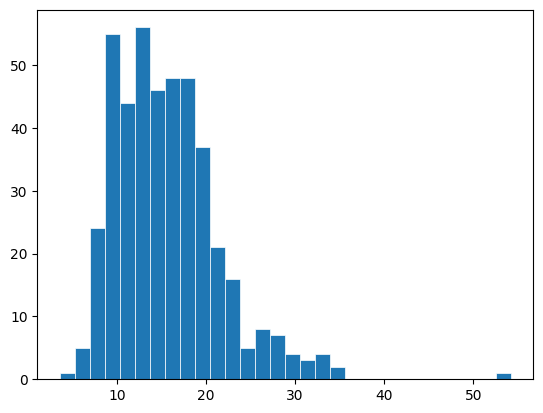

In [44]:
# plot runtimes
runtimes_ms = [rt/1_000_000 for rt in runtimes]
fig, ax = plt.subplots()
ax.hist(runtimes_ms, bins=30, linewidth=0.5, edgecolor="white")

In [45]:
for i in wrong_test_indices:
    print(tests[i])
    result = address_classification(tests[i])
    print(result, ground_truths[i], sep='\n')
    print('-' * 5)

357/28,Ng-T- Thuật,P1,Q3,TP.HồChíMinh.
{'province': 'Hồ Chí Minh', 'district': '1', 'ward': ''}
{'province': 'Hồ Chí Minh', 'district': '', 'ward': ''}
-----
284DBis Ng Văn Giáo, P3, Mỹ Tho, T.Giang.
{'province': 'Hà Giang', 'district': '', 'ward': ''}
{'province': 'Tiền Giang', 'district': 'Mỹ Tho', 'ward': '3'}
-----
59/12 Ng-B-Khiêm, Đa Kao Quận 1, TP. Hồ Chí Minh
{'province': 'Hồ Chí Minh', 'district': '12', 'ward': ''}
{'province': 'Hồ Chí Minh', 'district': '1', 'ward': 'Đa Kao'}
-----
290 Tùng Thiện- Vương,P.13, Quận 8, TP. Hồ Chí Minh.
{'province': 'Hồ Chí Minh', 'district': '1', 'ward': ''}
{'province': 'Hồ Chí Minh', 'district': '8', 'ward': '13'}
-----
Hà Tân Hưng Hà, Tân Hưng, Long An
{'province': 'Long An', 'district': 'Tân Hưng', 'ward': 'Tân Hưng'}
{'province': 'Long An', 'district': 'Tân Hưng', 'ward': 'Hưng Hà'}
-----
A:12A.21BlockA C/c BCA,P.AnKhánh,TP.Thủ Đức, TP. HCM
{'province': 'Khánh Hòa', 'district': '', 'ward': ''}
{'province': 'Hồ Chí Minh', 'district': 'Thủ Đ

{'province': 'Long An', 'district': '', 'ward': ''}
{'district': 'Lai Vung', 'ward': 'Long Thắng', 'province': ''}
-----
 Bằng Lng,,T.Bắc Kạn
{'province': 'Bắc Kạn', 'district': '', 'ward': ''}
{'district': '', 'ward': 'Bằng Lũng', 'province': 'Bắc Kạn'}
-----
X. Tân An, HuyệnThnh Hà, 
{'province': 'Thanh Hóa', 'district': '', 'ward': ''}
{'district': 'Thanh Hà', 'ward': 'Tân An', 'province': ''}
-----
XãtrBung Thanh,,TThanh Hóa
{'province': 'Thanh Hóa', 'district': 'Thanh Hóa', 'ward': ''}
{'district': '', 'ward': 'Trung Thành', 'province': 'Thanh Hóa'}
-----
vĩnh Hưng, , Long An
{'province': 'Long An', 'district': 'Vĩnh Hưng', 'ward': ''}
{'district': '', 'ward': 'Vĩnh Hưng', 'province': 'Long An'}
-----
Phường 04,,Thành phốHồ Chi Minh
{'province': 'Hồ Chí Minh', 'district': '4', 'ward': ''}
{'district': '', 'ward': '04', 'province': 'Hồ Chí Minh'}
-----
Xã Nâm Ntừ  Nậm Pồ 
{'province': '', 'district': '', 'ward': ''}
{'district': 'Nậm Pồ', 'ward': 'Nậm Nhừ', 'province': ''}
-----
X 

{'province': 'Lai Châu', 'district': '', 'ward': ''}
{'district': 'Hương Thủy', 'ward': 'Thủy Châu', 'province': 'Thừa Thiên Huế'}
-----
Thi trấ Ea. Knốp,H. Ea Kar,
{'province': '', 'district': '', 'ward': ''}
{'district': 'Ea Kar', 'ward': 'Ea Knốp', 'province': ''}
-----
X.Nga Thanh hyện Nga son TỉnhThanhQ Hóa
{'province': 'Thanh Hóa', 'district': 'Như Thanh', 'ward': ''}
{'district': 'Nga Sơn', 'ward': 'Nga Thanh', 'province': 'Thanh Hóa'}
-----
F Tân bình  dĩ An 
{'province': 'Tây Ninh', 'district': '', 'ward': ''}
{'district': 'Dĩ An', 'ward': 'Tân Bình', 'province': ''}
-----
x2Trung Sơn,,TỉnhNghê An
{'province': 'Nghệ An', 'district': 'Anh Sơn', 'ward': ''}
{'district': '', 'ward': 'Trung Sơn', 'province': 'Nghệ An'}
-----


In [46]:
addr = 'Đông thanh AnE Minh T kien Giang'
address_classification(addr, debug=True)

Đông thanh AnE Minh T kie
[(0.6833333333333332, (14, 16), 'Hà Nội'), (0.2625, (26, 31), 'Hà Giang'), (0.6375, (29, 31), 'Cao Bằng'), (0.7285714285714285, (10, 12), 'Bắc Kạn'), (0.5545454545454546, (25, 31), 'Tuyên Quang'), (0.7285714285714285, (14, 16), 'Lào Cai'), (0.4555555555555555, (23, 30), 'Điện Biên'), (0.7625, (4, 6), 'Lai Châu'), (0.6833333333333332, (25, 26), 'Sơn La'), (0.5857142857142856, (25, 28), 'Yên Bái'), (0.6375, (14, 18), 'Hoà Bình'), (0.7363636363636363, (9, 12), 'Thái Nguyên'), (0.6375, (2, 4), 'Lạng Sơn'), (0.51, (12, 18), 'Quảng Ninh'), (0.34444444444444444, (26, 31), 'Bắc Giang'), (0.5857142857142856, (18, 20), 'Phú Thọ'), (0.6777777777777777, (2, 6), 'Vĩnh Phúc'), (0.5125, (14, 18), 'Bắc Ninh'), (0.6777777777777777, (28, 31), 'Hải Dương'), (0.6777777777777777, (4, 8), 'Hải Phòng'), (0.6375, (2, 4), 'Hưng Yên'), (0.6777777777777777, (6, 9), 'Thái Bình'), (0.85, (4, 4), 'Hà Nam'), (0.6375, (7, 9), 'Nam Định'), (0.5666666666666667, (8, 12), 'Ninh Bình'), (0.455555

{'province': 'An Giang', 'district': '', 'ward': ''}